# 1 - Introduction
Welcome to this competition Notebook. Here we aim to develop a  model for identifying age-related conditions based on various data features. **Throughout the chat, we have explored important concepts such as cross-validation, evaluation metrics, handling class imbalance, hyperparameter tuning, and model performance analysis**. By leveraging these techniques, we strive to build an effective solution to predict age-related conditions. Join us on this journey as we uncover insights and enhance our model's performance.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # For visualization
import seaborn as sns # High level visualization
from scipy.stats import skew, kurtosis # Statistical analisys

# -----------DEFINE DEFAULT PARAMETERS OF MATPLOTLIB---------------
# Set the DPI (dots per inch) for the figures
plt.rcParams["figure.dpi"] = 150
# Set the default figure size for plots
plt.rcParams["figure.figsize"] = (12,5)
# Enable gridlines on the axes of plots
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 0.5
# -----------------------------------------------------------------

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 2-  Meet and greet data
Let's explore the Kaggle info

## 2.1 - Files and Field Descriptions
* **train.csv** - The training set.
    * `Id` Unique identifier for each observation.
    * `AB-GL` Fifty-six anonymized health characteristics. All are numeric except for `EJ`, which is categorical.
    * `Class` A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.

* **test.csv** - The test set. The goal is to predict the probability that a subject in this set belongs to each of the two classes.
* **greeks.csv** - Supplemental metadata, only available for the training set.
    * `Alpha` Identifies the type of age-related condition, if present.
    * `A` No age-related condition. Corresponds to class 0.
    * `B`, `D`, `G` The three age-related conditions. Correspond to class 1.
    * `Beta`, `Gamma`, `Delta` Three experimental characteristics.
    * `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [2]:
# Read the datasets
train = pd.read_csv('../DATA/input/train.csv')
test = pd.read_csv('../DATA/input/test.csv')
greeks = pd.read_csv('../DATA/input/greeks.csv')

# Clean the blank spaces
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [3]:
# Print Shapes od the data frames
print(f'The train set has {train.shape[0]} entries and {train.shape[1]} columns')
print(f'The test set has {test.shape[0]} entries and {test.shape[1]} columns')
print(f'The greeks set has {greeks.shape[0]} entries and {greeks.shape[1]} columns')

The train set has 617 entries and 58 columns
The test set has 5 entries and 57 columns
The greeks set has 617 entries and 6 columns


All features columns have a two-character name. `Class` represents the target and `Id` is not relevant for this analysis. 

In [4]:
# Get columns names
train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

# 3 - Exploratory data Analisys
We should never skip this part

In [5]:
# Obtain the columns name for the exploratory data analisys
cat_feat = 'EJ'
num_feat = list(train.columns[1:-1])
num_feat.remove(cat_feat)

The standard deviation, the maximum and minimum values differ greatly

In [6]:
# Describe numerical features
train[num_feat].describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,11.516657,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,35.851039,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000


In [7]:
# Counts numerical features
train[cat_feat].value_counts()

B    395
A    222
Name: EJ, dtype: int64

In [8]:
# Count Missing values
print('Missing values per feature:')
missing_dt = pd.isnull(train).sum()[pd.isnull(train).sum() > 0].sort_values(ascending=False)
missing_dt

Missing values per feature:


BQ    60
EL    60
CC     3
CB     2
FS     2
DU     1
FC     1
FL     1
GL     1
dtype: int64

It appears that **we have missing values in only two features**, which account for approximately 10% of the total dataset. The remaining features have insignificant amounts of missing values. We need to devise a strategy to handle these missing values.

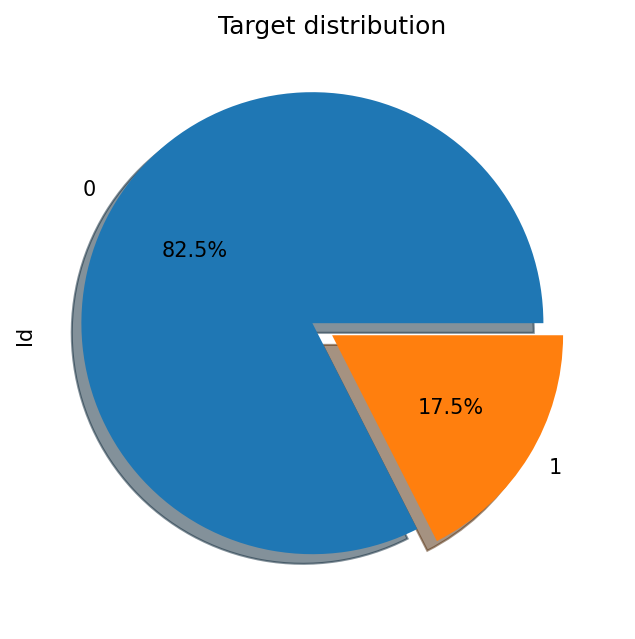

In [9]:
# Plot the distribution fo the target
train.groupby('Class').count()['Id'].plot.pie(title='Target distribution', autopct='%1.1f%%', shadow=True, explode=(0.1, 0))
plt.show()

We can see that **the distribution of the dependent variable (Class) is not symmetric.** There are about 4 times more entries referring to 0 (without diseases) than to 1 (with diseases). This is a very important point because the classification algorithms are sensitive to imbalance. It is imperative to define a strategy to avoid bias.

## 3.1 - Standard deviation, mean, skewness and kurtosis
An array with all the values was created to be analyzed if necessary

In [10]:
# Calculate the standard deviation, mean, skewness and kurtosis for each numerical feature in the 'train' dataset
std_values = np.std(train[num_feat],axis=0).values
mean_values = train[num_feat].mean(axis=0).values
skew_values = skew(train[num_feat])
kurt_values = kurtosis(train[num_feat])

# Create a dictionary with previous results
stat_dict = {'STD':std_values,
             'MEAN':mean_values,
             'SKEW':skew_values,
             'KURTOSIS':kurt_values}

# Store data in a DataFrame
stats_dataframe = pd.DataFrame(stat_dict,index=num_feat)
stats_dataframe.head()

,STD,MEAN,SKEW,KURTOSIS
AB,0.468009,0.477149,5.912825,52.589535
AF,2298.457842,3502.013221,3.741932,29.793933
AH,127.735311,118.624513,10.069627,122.868973
AM,69.671697,38.968552,6.419314,48.180678
AR,10.510350,10.128242,13.227018,201.024027


## 3.2 - Distribution 
An image says more than 100 dataframes. It's a good idea to create a function to graph the distributions.

In [11]:
def plot_dist(data, features, init=0, target_name='Class'):
    """
    Plots the distribution of features in a dataset using kernel density estimation (KDE) plots and box plots.

    Parameters:
        data (pd.DataFrame): The input dataset for which the distribution is to be plotted.
        features (list): A list of features from the dataset for which the distribution will be plotted.
        init (int, optional): Starting index of the features to be plotted. Default is 0.
        target_name (str, optional): The name of the target variable used for grouping and distinguishing the distributions. Default is 'Class'.

    Returns:
        None

    Example:
        plot_dist(data=train_data, features=feature_list, init=0, target_name='Class')
    """
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,5))
    axs = axs.flatten()

    for j in range(0,10):
        if j < 5:
            index = j + init
            mu = round(data[features[index]].mean(),2)
            sigma = round(np.std(data[features[index]]),2)
            
            # Plot KDE for each feature
            sns.kdeplot(data=data,x=features[index],hue=target_name, ax=axs[j]) 
            axs[j].title.set_text(f'KDE: $\mu=${mu}, $\sigma=${sigma}')
            axs[j].title.set_fontsize(9)
        else:
            index = j + init - 5
            maxi = round(np.max(data[features[index]]))
            mini = round(np.min(data[features[index]]))
            
            # Plot box plot for each feature
            sns.boxplot(data=data,y=features[index],x=target_name,ax=axs[j])
            axs[j].title.set_text(f'BOX: max:{maxi}, min:{mini}')
            axs[j].title.set_fontsize(9)
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.suptitle('Distribution')
    plt.show()

Here only the distribution of the first 20 features is shown to avoid overloading with graphics. It is evident that **the distributions of classes 0 and 1 are different**. In addition, both **the mean and the standard deviation have a very large range of values**.

*Will a normalization be necessary to reduce convergence times and correctly analyze the weight of each feature?*

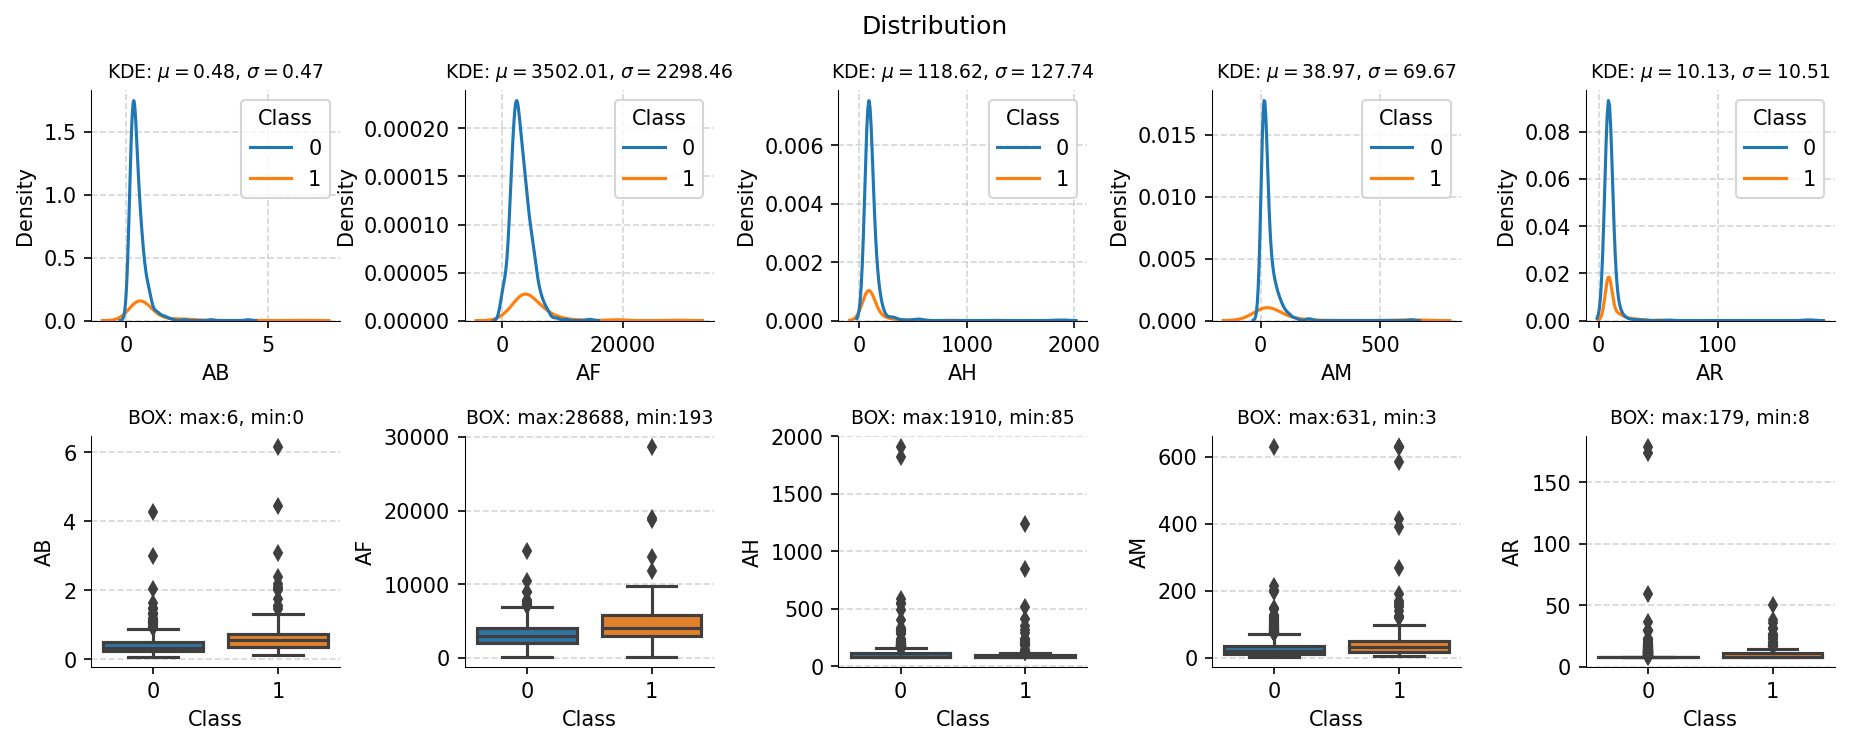

In [12]:
plot_dist(train,num_feat)

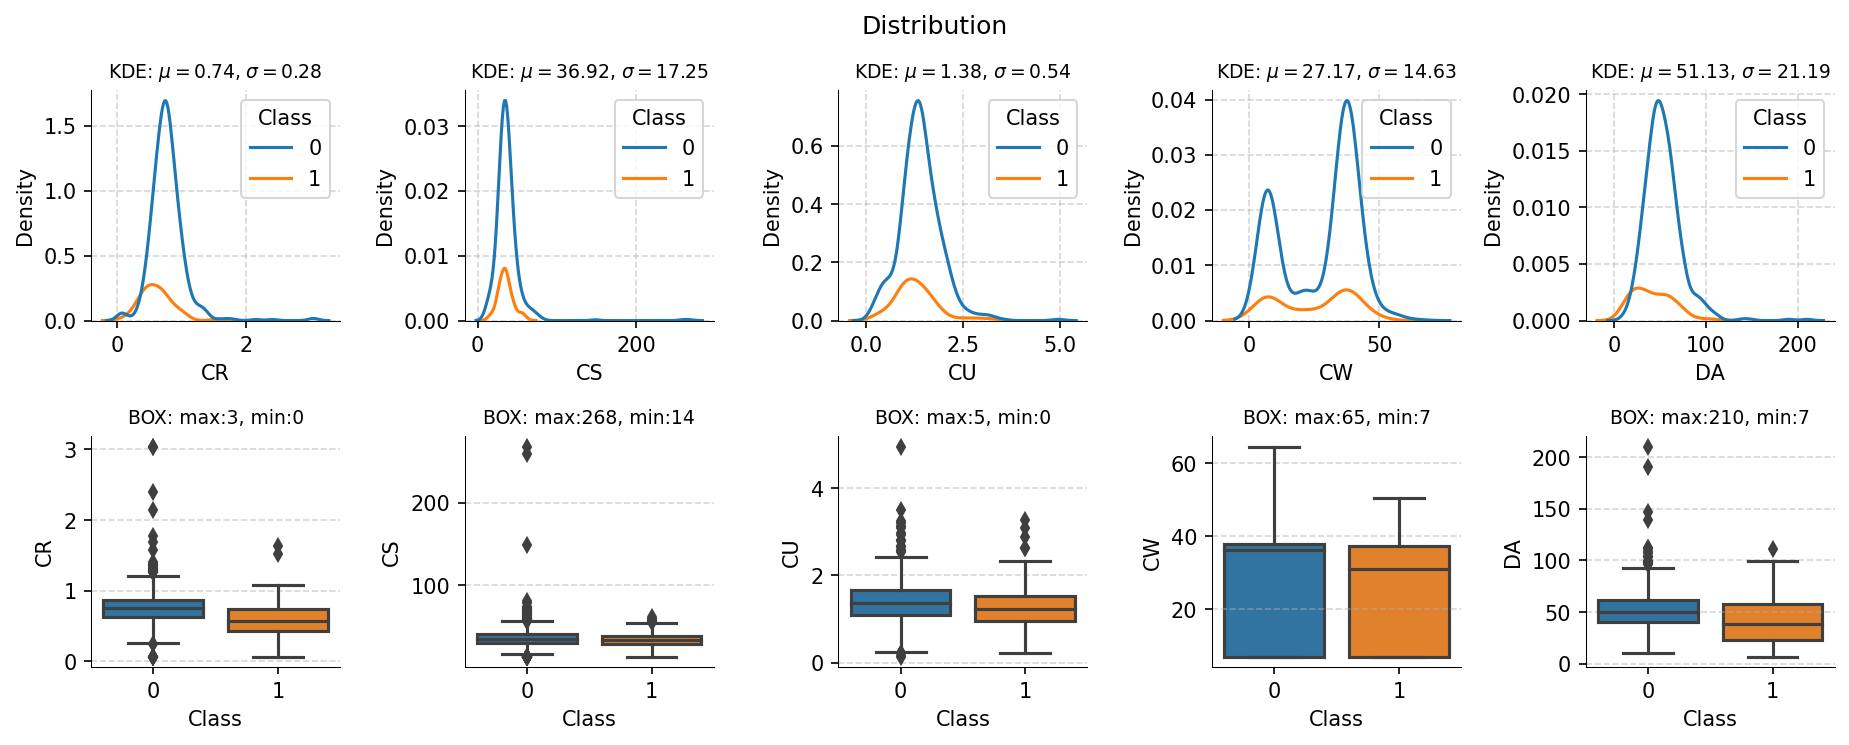

In [13]:
plot_dist(train,num_feat,init=21)

## 3.3 - Correlation
Analyzing the correlation is an excellent starting point to better understand the relationship between the independent variables and the dependent variable.
It is clearly observed that **there is a correlation between the dependent variables**.

<Axes: >

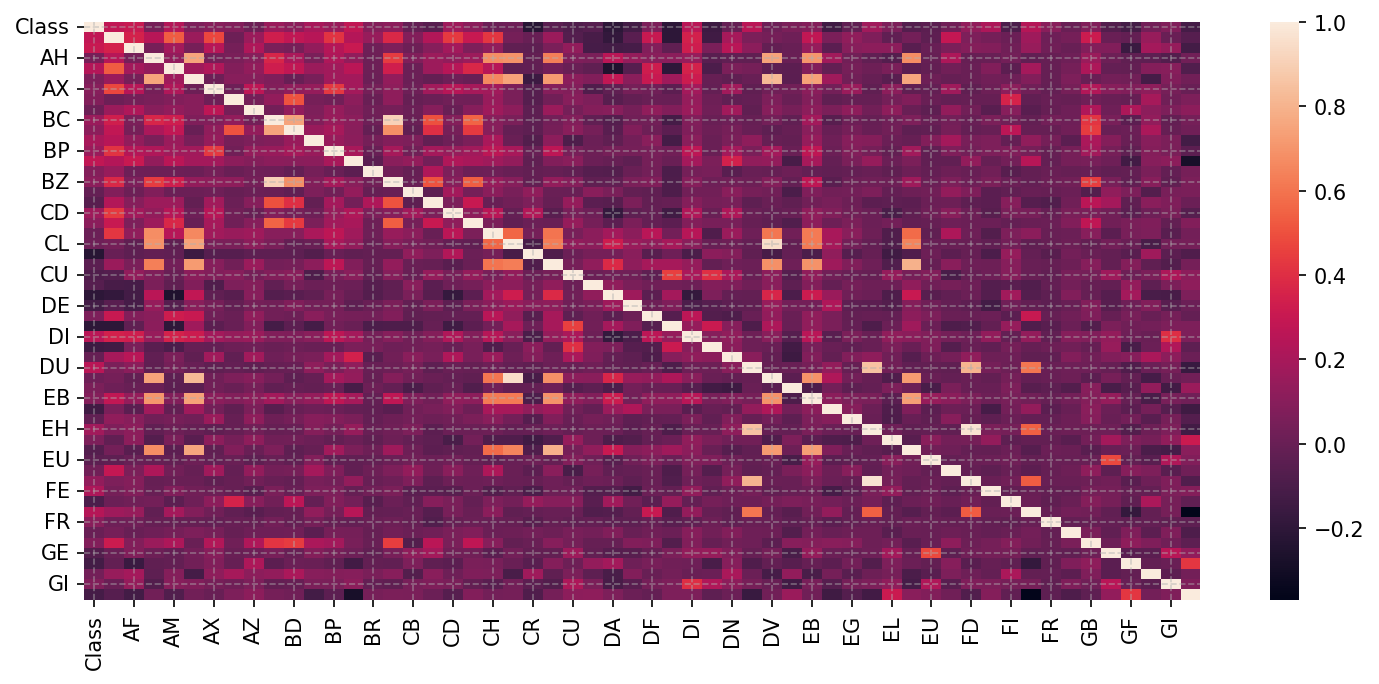

In [14]:
# Heatmap of numerical features and target correlation
corr_all = train[['Class'] + num_feat].corr()
sns.heatmap(data=corr_all)

The 10 independent variables with the highest correlation with the dependent variable were extracted.

*Doing this exercise for the `Greeks` set would be a good idea.*

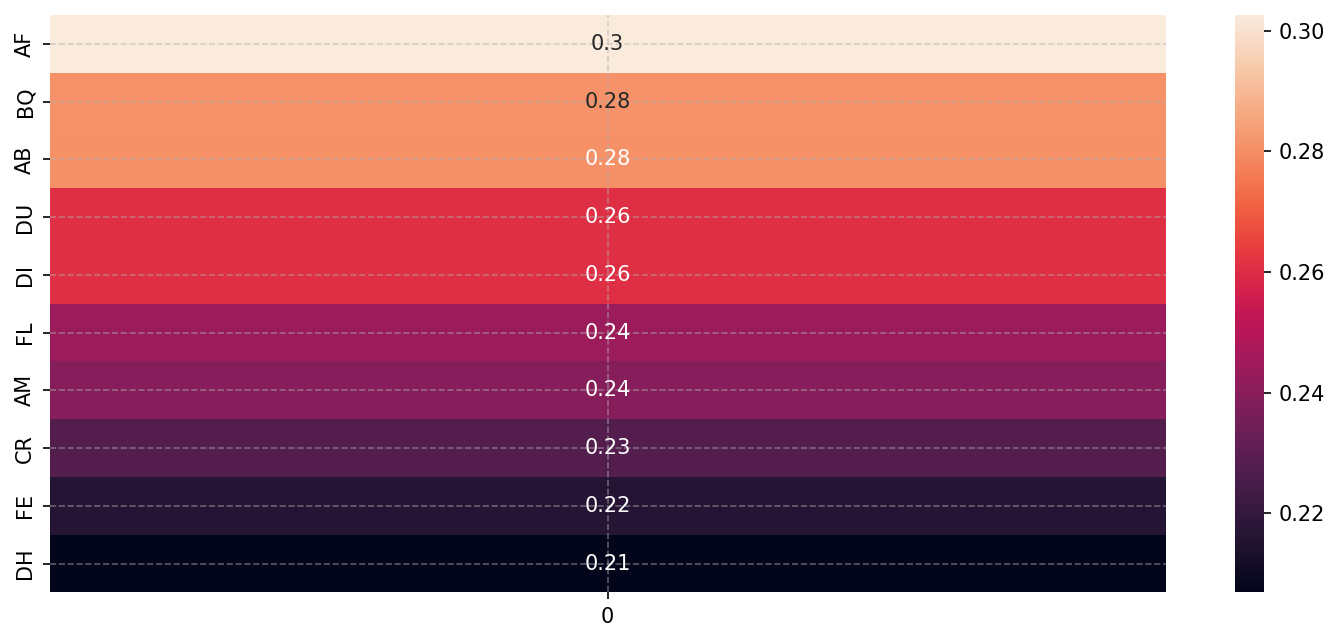

In [15]:
# Calculate the absolute correlation between each feature and the target variable
corr_target = np.abs(train[num_feat].corrwith(train['Class']))
corr_target = corr_target.sort_values(ascending=False)

# Create a heatmap to visualize the top 10 correlations
sns.heatmap(data=corr_target.iloc[:10].to_frame(),annot=True)
plt.show()

We are going to analyze in more detail the correlation between independent variables (features)

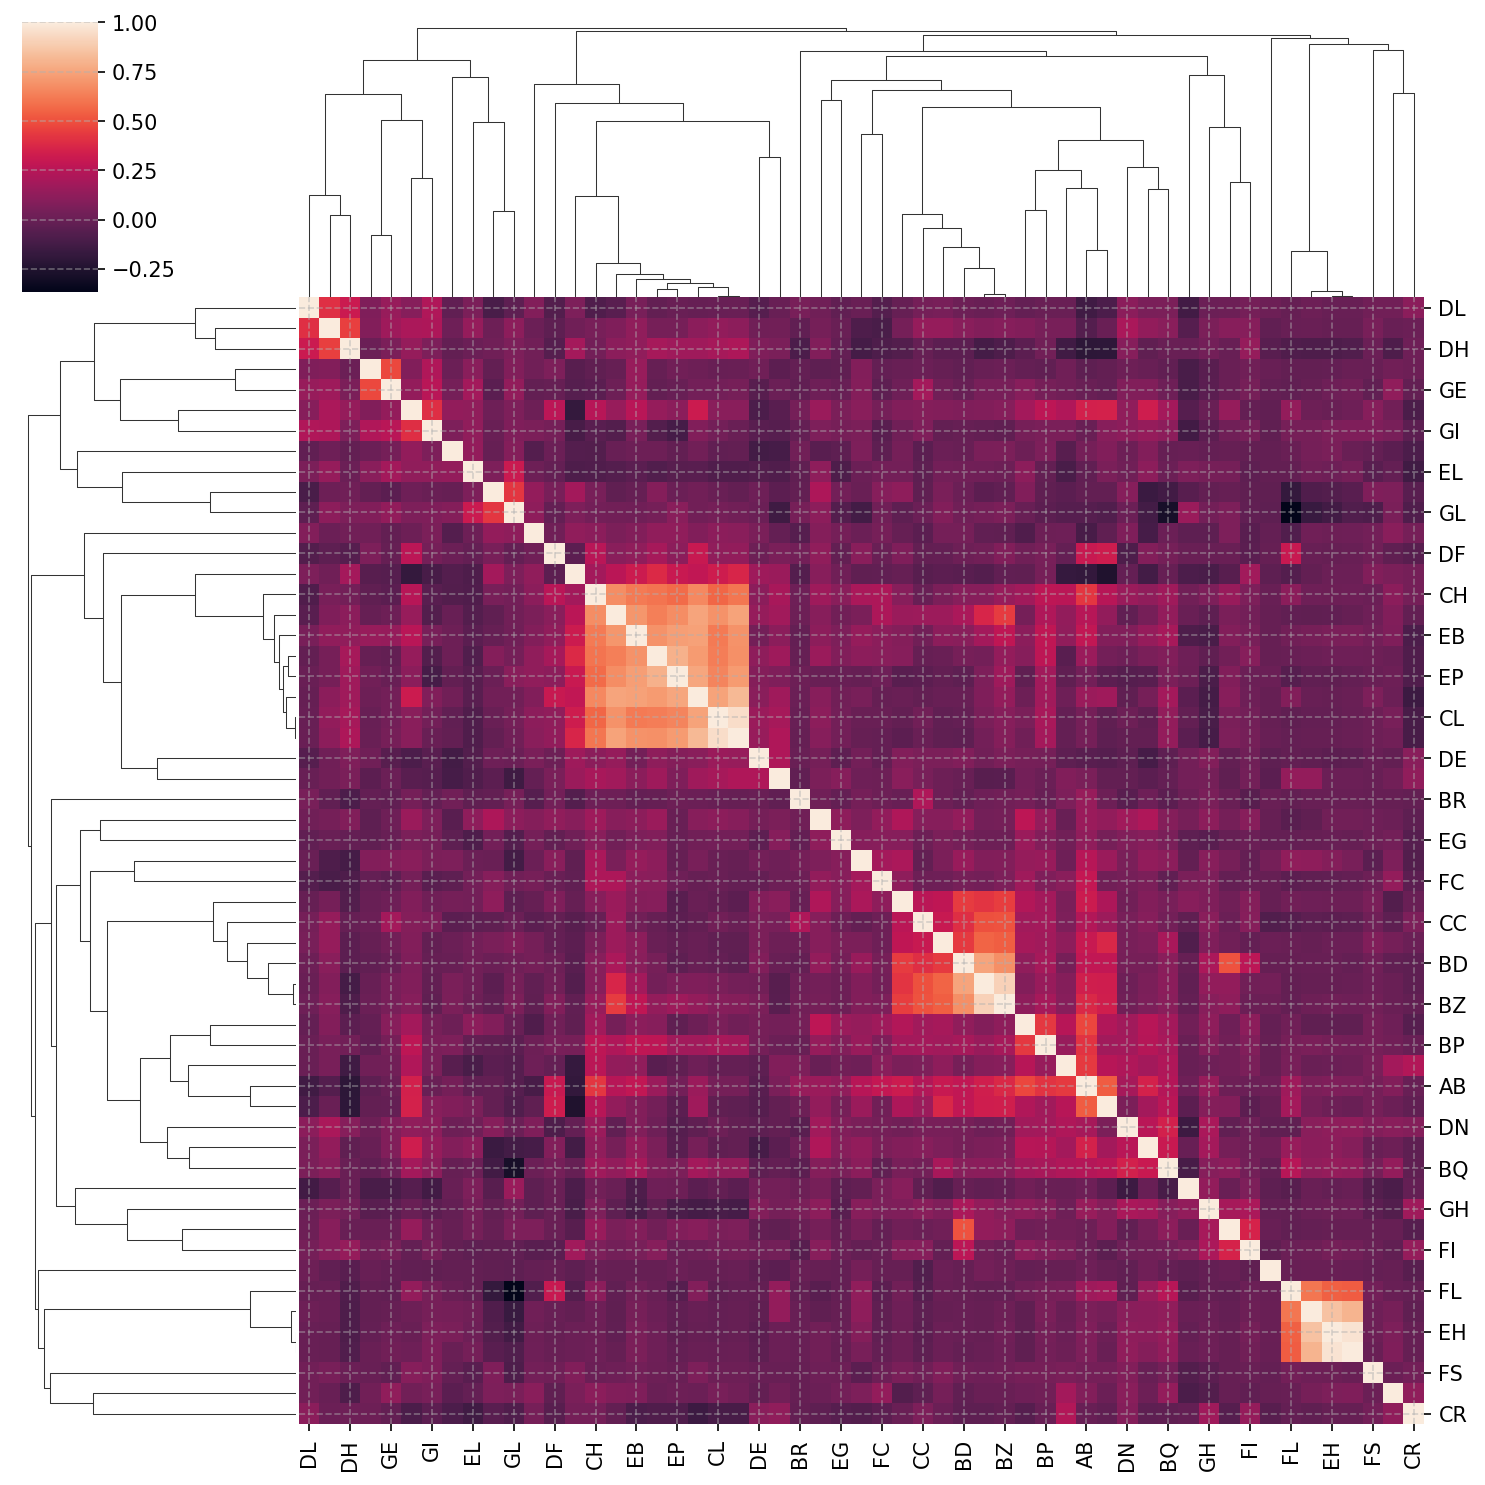

In [16]:
sns.clustermap(data=train[num_feat].corr(),metric="correlation")
plt.show()

In [17]:
# Calculate the absolute correlation matrix between the numerical features
feat_corr = train[num_feat].corr().abs().unstack()
# Remove self-correlations and select the 20 largest
feat_corr = feat_corr[feat_corr < 1].drop_duplicates().nlargest(10)
feat_corr

EH  FD    0.971152
CL  DV    0.948991
BC  BZ    0.907981
DU  EH    0.850957
AR  DV    0.823012
DU  FD    0.805989
CS  EP    0.794158
AR  EP    0.754615
BC  BD    0.753051
AH  AR    0.749794
dtype: float64

In [18]:
def plot_scatter(data, feat_corr):
    """
    Plot scatter plots for the top 10 feature correlations.
    
    Parameters:
    - data (DataFrame): The data containing the features.
    - feat_corr (Series): Series containing the top feature correlations.
    
    """
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,5))
    axs = axs.flatten()
    
    # Get the features from the feat_corr index (tupple)
    features = feat_corr.index

    for j in range(0,10):
        sns.scatterplot(data=data,x=features[j][0],y=features[j][1],alpha=0.7,ax=axs[j])
        
        # Get the correlation value for the current feature pair
        corr = round(feat_corr.values[j],4)
        
        # Set the title for the scatter plot with the correlation value
        axs[j].title.set_text(f'$\\rho_{{xy}}=${corr}')
        axs[j].title.set_fontsize(9)
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.suptitle('Scatterplot between correlated features')
    plt.show()

**There is a strong correlation between dependent variables**. The scatterplot shows the top 10. It may be possible to infer the value of the missing data through other available features. In another version this will be tested

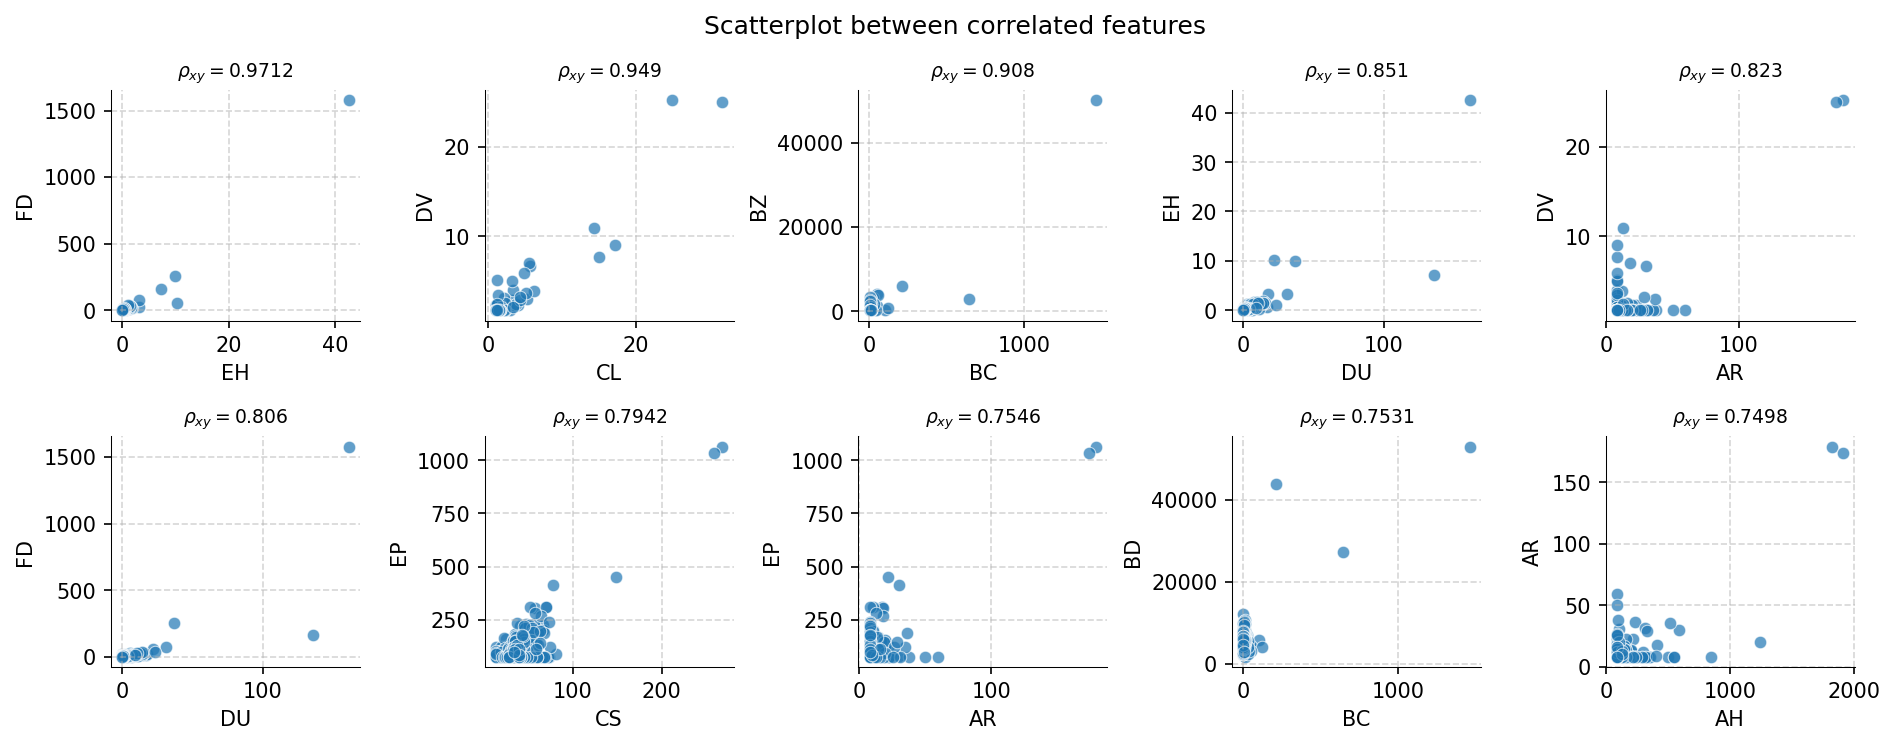

In [19]:
plot_scatter(train,feat_corr)

Finally, the categorical variables

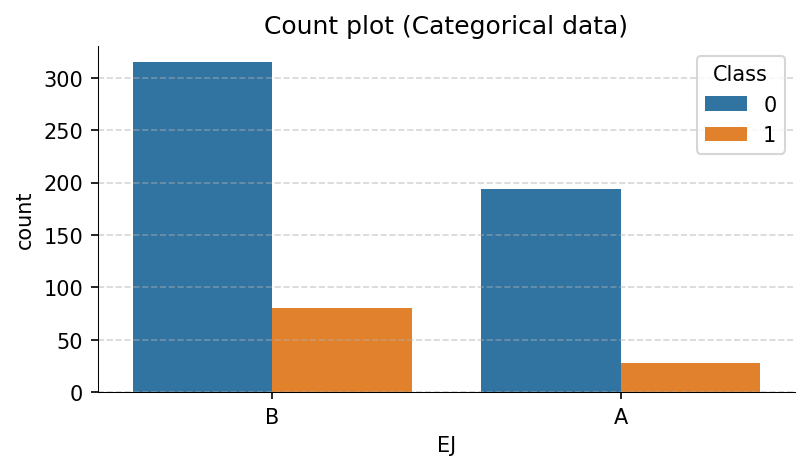

In [20]:
plt.figure(figsize=(6,3))
sns.countplot(data=train,x='EJ',hue='Class')
plt.title('Count plot (Categorical data)')
plt.show()

# 4 - Pre procesing
First of all, we are going to fill in the missing values with the mean of each independent variable.



In [21]:
for feature in missing_dt.index.tolist():
    # Calculate the mean of the missing feature
    mean = train[feature].mean()
    train[feature].fillna(mean,inplace=True)

In [22]:
print(f'Missing values: {pd.isnull(train).sum().sum()}')

Missing values: 0


For this competition all the values of `train.csv` can be used for training the model. However, **it is a good idea to 'set aside' a couple of subsets for the validation and test to ensure that overfitting has not occurred**. In this particular case the amount of data available for training is limited, therefore **using cross validation seems to be a better alternative**. However, we are going to use both methods, separating a set to evaluate the performance with data never seen before. This with the purpose of demonstrating the importance of cross validation for a correct evaluation of the model.

**Note**: Use `LabelEncoder()` instead of `pd.get_dummies()` because sample file `test.csv` does not contain the value 'B' for the categorical variable.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Use label enconder insead of dummy
encoder = LabelEncoder()

# Perform Label encoding on the features and assign them to X
X = train.drop(['Id','Class'],axis=1)
X[cat_feat] = encoder.fit_transform(train[cat_feat])
# Assign the target variable to y
y = train['Class']

# Split the data into train, test, and validation sets
X_train_prev, X_test, y_train_prev, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_prev, y_train_prev, test_size=0.10, random_state=42)

print(f'Shape of the "Train set": {X_train.shape}')
print(f'Shape of the "Validation set": {X_val.shape}')
print(f'Shape of the "Test set": {X_test.shape}')

Shape of the "Train set": (499, 56)
Shape of the "Validation set": (56, 56)
Shape of the "Test set": (62, 56)


In order not to lose ourselves with the split, I made this figure: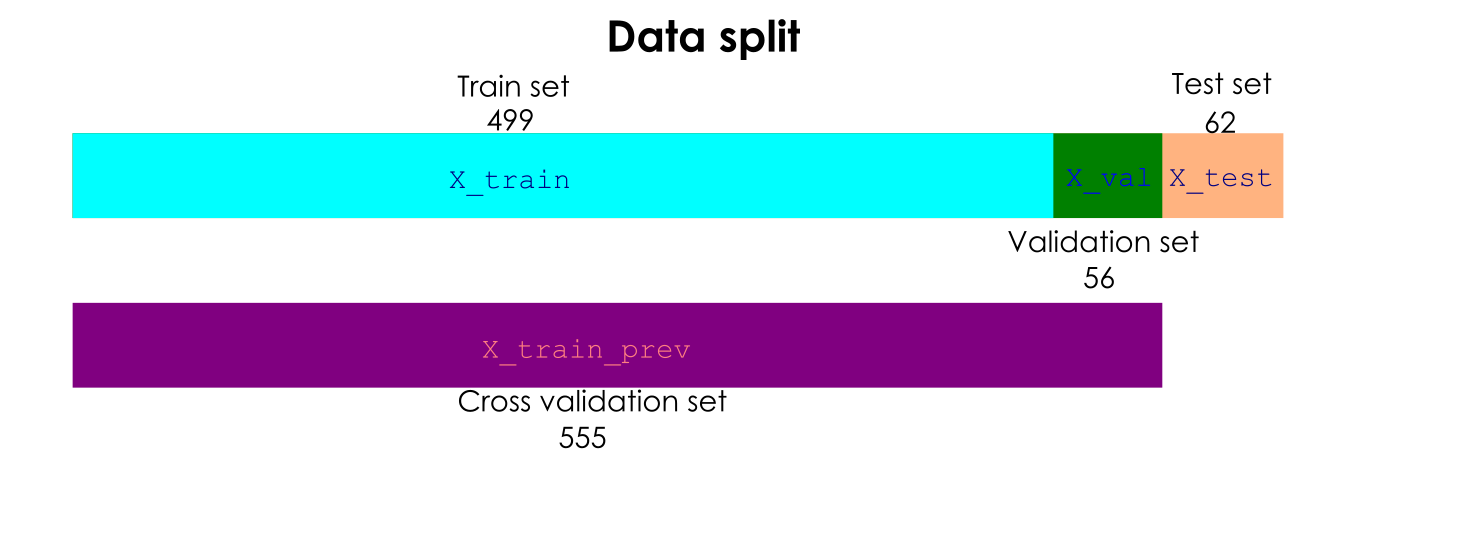

Most of the algorithms that we are going to use do not require **standardization**, however, in the case of logistic regression, this **helps to improve the convergence time.**

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Standardize the features in the train set
X_train_std = scaler.fit_transform(X_train)
# Standardize the features in the validation set (DON'T FIT)
X_val_std = scaler.transform(X_val)

## 4.1 - Class imbalance

As previously observed, there is an imbalance of 1 to 5 between the target variable `Class`. To solve this, the **class weight method will be used** because the resamplig will result in a very small amount of data.

In [25]:
ratio = round(train.groupby('Class').count().loc[0,'Id'] / train.groupby('Class').count().loc[1,'Id'])
print(f'The aprox ratio of the imbalance is 1/{ratio}')

The aprox ratio of the imbalance is 1/5


# 5 - Machine learning
In this section we will evaluate some of the most popular models for classification problems. Later we will select one based on its metrics and it will be tuned to improve it. The models are:

* Logistic Regression
* Support Vector Clasifier
* Random Forest
* Gradient Boosting

## 5.1 - The Crucial Role of Cross-Validation and Selecting Appropriate Evaluation Metrics
However, before diving into the exciting details, let's take a moment to discuss the significance of conducting an evaluation using cross-validation and selecting the appropriate evaluation metric for accurate assessment.

We will follow the conventional approach of using a separate training set and validation set (with the test set remaining untouched until the end, as per standard practice). We already note that our data is imbalanced, but intentionally, we will not make any adjustments to address this.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define class weights identical
class_weights = {0: 1.0, 1: 1.0}

# Create and train the logistic regression model with class weights
LR_model = LogisticRegression(solver='liblinear',class_weight=class_weights)
LR_model.fit(X_train_std,y_train)

# Make predictions on the validation set and evaluation
preds = LR_model.predict(X_val_std)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.80      0.67      0.73         6

    accuracy                           0.95        56
   macro avg       0.88      0.82      0.85        56
weighted avg       0.94      0.95      0.94        56



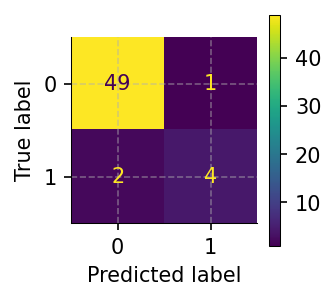

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(y_val,preds)

fig, ax = plt.subplots(figsize=(2, 2))

# Create a ConfusionMatrixDisplay object and plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Our model exhibits a high **accuracy of 95%**, furthermore, we can correctly identify almost all negative values (0). However, considering the class imbalance, there is potential for further improvement in the model's performance (thought).

In [28]:
# Define class weights with 1-5 ratio
class_weights = {0: 1.0, 1: 5.0}
LR_model = LogisticRegression(solver='liblinear',class_weight=class_weights)
LR_model.fit(X_train_std,y_train)

preds = LR_model.predict(X_val_std)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        50
           1       0.56      0.83      0.67         6

    accuracy                           0.91        56
   macro avg       0.77      0.88      0.81        56
weighted avg       0.93      0.91      0.92        56



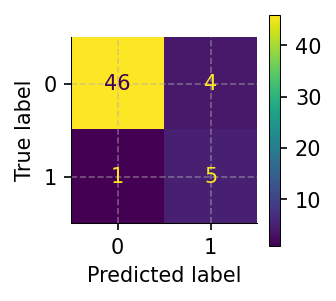

In [29]:
cm = confusion_matrix(y_val,preds)

fig, ax = plt.subplots(figsize=(2, 2))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

But... when using the `class_weights` parameter, **it appears that we have obtained worse overall results** and definetly less accuracy. However, upon closer examination of the recall score for class 1, we can observe an increase, that is why we also observe an increase in the count of true positives (from 4 to 5), with only one misclassification in class 1 (false negative). However, there is also an increase in the count of false positives (from 1 to 4), resulting in a decrease in the precision of class 1. This is getting complicated right?, it can be quite challenging to determine if our model is truly improving or not.

At this point, **the importance of cross-validation becomes evident**. In the initial evaluation, we achieved a precision of 95%, which is impressive. However, we must acknowledge that this optimism is based on a small randomly selected subset of data, consisting of only 56 samples. This can be considered as a placebo effect, as it provides an overly optimistic and unrealistic assessment.

**First of all, we need to obtain a more realistic evaluation. We definetly need to utilize all available data and account for its rich and diverse distribution**. This can be achieved through the use of cross-validation, which allows us to assess the model's performance across multiple iterations and different subsets of the data.

If You are unfamiliar to cross validation read this [LINK](https://scikit-learn.org/stable/modules/cross_validation.html).

In [30]:
from sklearn.model_selection import cross_validate

def alg_ev(models,X_train,y_train,cv=10):
    """
    Evaluate the performance of classification models using cross-validation.

    Parameters:
        models (list): List of classification models to evaluate.
        X_train (array-like): Training data features.
        y_train (array-like): Training data target.
        cv (int, optional): Number of cross-validation folds. Default is 10.

    Returns:
        DataFrame: Evaluation results containing algorithm name, training time,
                   accuracy, balanced accuracy, F1 score, precision, and recall.

    """
    scoring = ['accuracy','balanced_accuracy', 'f1', 'precision', 'recall']
    name = []
    fit_time = []
    test_accuracy = []
    test_balanced_accuracy = []
    test_f1 = []
    test_precision = []
    test_recall = []

    for model in models:
        # Perform cross-validation and calculate scores
        scores = cross_validate(model,X_train,y_train,cv=cv,scoring=scoring)
        
        # Collect algorithm name and average scores
        name.append(model.__class__.__name__)
        fit_time.append(np.mean(scores['fit_time']))
        test_accuracy.append(np.mean(scores['test_accuracy']))
        test_balanced_accuracy.append(np.mean(scores['test_balanced_accuracy']))
        test_f1.append(np.mean(scores['test_f1']))
        test_precision.append(np.mean(scores['test_precision']))
        test_recall.append(np.mean(scores['test_recall']))

    # Create a dictionary with evaluation results
    comp_dic = {
        'Algoritm': name,
        'Training time': fit_time, 
        'Accuracy': test_accuracy,
        'Balanced Accuracy': test_balanced_accuracy,
        'F1 score': test_f1,
        'Precision': test_precision,
        'Recall': test_recall
    }

    # Convert the dictionary to a DataFrame and return it
    return pd.DataFrame(data=comp_dic)

The previous function will be extremely useful for evaluating the performance of the models. It has been enhanced with additional metrics to provide a more comprehensive understanding of their performance.

Let's try it:

In [31]:
LR_unbal_model = LogisticRegression(solver='liblinear')
LR_bal_model = LogisticRegression(solver='liblinear',class_weight='balanced')

models = [LR_unbal_model,LR_bal_model]

# Standardize the features (better convergence time)
X_train_prev_std = scaler.fit_transform(X_train_prev)

# Perform algorithm evaluation
logreg_df = alg_ev(models,X_train_prev_std,y_train_prev)
logreg_df['Weight'] = ['Unbalanced','Balanced']
logreg_df

,Algoritm,Training time,Accuracy,Balanced Accuracy,F1 score,Precision,Recall,Weight
0,LogisticRegression,0.005087,0.888247,0.776715,0.642732,0.712532,0.607778,Unbalanced
1,LogisticRegression,0.006399,0.868344,0.828454,0.670004,0.606194,0.767778,Balanced


Now **we have a much more realistic accuracy** as we have averaged the results from each fold. We have addressed one aspect, but we still observe a higher accuracy when we do not consider the class imbalance. Should we simply ignore it? Should we pretend that nothing is wrong and not address it in any way? The answer is NO. We need to delve deeper into the metrics to gain a better understanding.

in summary:

- [**Accuracy**](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score): Accuracy is a commonly used metric that measures the overall correctness of a model's predictions. It is calculated as the ratio of the number of correct predictions to the total number of predictions. Accuracy provides an intuitive measure of how well the model performs in terms of correctly classifying samples. However, **it can be misleading when dealing with imbalanced datasets, as it may be high even if the model primarily predicts the majority class**. Therefore, it is important to consider other metrics, such as precision, recall, or the F1 score, to obtain a more comprehensive evaluation of the model's performance.
- [**F1 score**](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics): The F1 score is a metric for binary classification tasks. It combines both precision and recall into a single value. [Precision](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) is the ratio of true positives to the sum of true positives and false positives, and it measures the model's ability to correctly identify positive samples. [Recall](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics), also known as sensitivity or true positive rate, is the ratio of true positives to the sum of true positives and false negatives, and it measures the model's ability to correctly identify all positive samples. The F1 score is the harmonic mean of precision and recall, providing a balanced evaluation of the model's performance. **It is especially useful when dealing with imbalanced datasets, where one class may have significantly more samples than the other**.

There is also another useful metric, the [balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score) which is a metric that takes into account the imbalance in the class distribution. It calculates the average of the sensitivity (true positive rate) for each class, giving equal weight to both classes. When comparing the balanced accuracy and the F1 score, it's important to note that they capture different aspects of the model's performance. The balanced accuracy specifically addresses the issue of class imbalance by considering the sensitivity for each class, while the F1 score focuses on the trade-off between precision and recall.

Now we have a better understanding of the most reliable metrics to analyze the performance of our models in this specific problem. Furthermore, it is evident that **the overall performance of our logistic regression algorithm slightly improved when accounting for the class imbalance**.

## 5.2 Models Evaluation
Returning to the core of this project, we are going to evaluate the raw performance of each algorithm.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Create instances of the models
LR_model = LogisticRegression(solver='liblinear',class_weight='balanced',random_state=42)
SVC_model = SVC(kernel='rbf',class_weight='balanced',random_state=42)
RF_model = RandomForestClassifier(criterion='gini',random_state=42)
GB_model = GradientBoostingClassifier(criterion='friedman_mse',random_state=42)

models = [LR_model,SVC_model,RF_model,GB_model]

alg_ev(models,X_train_prev_std,y_train_prev)

,Algoritm,Training time,Accuracy,Balanced Accuracy,F1 score,Precision,Recall
0,LogisticRegression,0.008702,0.868344,0.828454,0.670004,0.606194,0.767778
1,SVC,0.010553,0.879156,0.795314,0.648012,0.655210,0.668889
2,RandomForestClassifier,0.296909,0.915292,0.781280,0.691137,0.898611,0.577778
3,GradientBoostingClassifier,0.797175,0.913442,0.804227,0.708637,0.840512,0.638889


At first glance, the Gradient Boosting Classifier (GBC) appears to be the winner in terms of F1 score, while logistic regression excels in balanced accuracy, demonstrating better recall. Considering the overall performance and robustness against overfitting, we will select the ensemble method (GBC) for further analysis.

## 5.3 Hyper-parameter tuning
Now, we will attempt to enhance the performance of the algorithm by tuning its hyperparameters. To accomplish this, we will utilize RandomizedSearchCV, which allows for a more computationally efficient search of the hyperparameter space. You can find more information about RandomizedSearchCV [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In [33]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Define the parameter grid with different values for hyperparameters
param_grid = {
    'learning_rate': [0.01,0.02,0.05,0.1,0.2,0.5,1,5,10],
    'n_estimators': [100,200,400,600,800],
    'max_depth': [2,3,4,5,7,10,15,20,30,40]
}

# Initialize the RandomizedSearchCV with the estimator, parameter grid, and other settings
GB_grid = RandomizedSearchCV(GradientBoostingClassifier(criterion='friedman_mse',random_state=42),
                             param_grid,n_iter=10,random_state=42)

# Fit the RandomizedSearchCV to perform the search over the parameter grid
GB_grid.fit(X_train_prev,y_train_prev)

RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.02, 0.05, 0.1,
                                                          0.2, 0.5, 1, 5, 10],
                                        'max_depth': [2, 3, 4, 5, 7, 10, 15, 20,
                                                      30, 40],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800]},
                   random_state=42)

These are the **best parameters according to the function**:

In [34]:
GB_grid.best_params_

{'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1}

Let's evaluate the tunning process

In [35]:
# Same evaluation as before
GB_tuned = GB_grid.best_estimator_

GB_model = GradientBoostingClassifier(criterion='friedman_mse',random_state=42)
models = [GB_tuned,GB_model]

comp_df = alg_ev(models,X_train_prev,y_train_prev)
comp_df['Tuned'] = ['yes','no']
comp_df

,Algoritm,Training time,Accuracy,Balanced Accuracy,F1 score,Precision,Recall,Tuned
0,GradientBoostingClassifier,3.212615,0.924318,0.828623,0.751099,0.864838,0.683333,yes
1,GradientBoostingClassifier,0.804929,0.913442,0.804227,0.708637,0.840512,0.638889,no


## 5.4 Out-of-sample evaluation (final)
Finally, we will assess the performance of our model on unseen data, which is crucial to evaluate its real-world behavior. It's important to note that once this evaluation is done, it is not recommended to make any further modifications to the model. This evaluation metric provides valuable insights into the model's performance in practical scenarios.

In [36]:
preds = GB_tuned.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        49
           1       1.00      0.77      0.87        13

    accuracy                           0.95        62
   macro avg       0.97      0.88      0.92        62
weighted avg       0.95      0.95      0.95        62



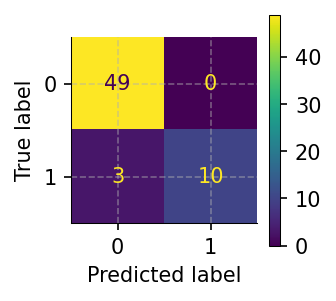

In [37]:
cm = confusion_matrix(y_test,preds)

fig, ax = plt.subplots(figsize=(2, 2))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()

Not bad, not bad at all. The model has achieved an F1 score of 95% and **We don't have any false positives**. While there is definitely room for improvement in reducing false negatives, for a first attempt using a *'common'* algorithm I consider it to be a good result.

# 6 - Retrain with all data and prepare for submision
Finally we are going to train the model with all the available data and create the dataframe required for the competition.

In [38]:
# Use params from RanmdomGridSearchCV
params = GB_grid.best_params_
final_model = GradientBoostingClassifier(criterion='friedman_mse',
                                         random_state=42,
                                         learning_rate=params['learning_rate'],
                                         n_estimators=params['n_estimators'],
                                         max_depth=params['max_depth'])

# Train with all available data
final_model.fit(X,y)

GradientBoostingClassifier(n_estimators=400, random_state=42)

In [39]:
id_data = test['Id']
test_data = test.drop('Id',axis=1)

# Don't fit the encoder, there is only 'A' (categorical) in test.csv (sample)
test_data[cat_feat] = encoder.transform(test_data[cat_feat])

In [40]:
# We need probabilities not only Clases
results_data = final_model.predict_proba(test_data)

submission_dict = {
    'Id': id_data,
    'class_0': results_data[:,0],
    'class_1': results_data[:,1]
}

submission = pd.DataFrame(submission_dict)
submission.to_csv('../DATA/output/submission.csv',index=False)
pd.read_csv('../DATA/output/submission.csv').head()

,Id,class_0,class_1
0,00eed32682bb,0.000006,0.999994
1,010ebe33f668,0.000006,0.999994
2,02fa521e1838,0.000006,0.999994
3,040e15f562a2,0.000006,0.999994
4,046e85c7cc7f,0.000006,0.999994


In [42]:
import joblib
joblib.dump(final_model,'../MODELS/model_v1.0.sav')

['../MODELS/model_v1.0.sav']

Thank you for your time, I hope that some of this content will be of help to you. I put a lot of love and effort into it. until next time